In [ ]:
import numpy as np
import pandas as pd
import json

from PIL import Image


import torch
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

import time
import matplotlib.pyplot as plt
# import logging
from datetime import datetime
import torch.nn as nn



from matplotlib.colors import LinearSegmentedColormap
import os
import zipfile

In [6]:
def max_width_spinneret(matrix_array):
    
    # Находим индексы элементов, не равных -1, для каждой строки 
    non_negative_indices = (matrix_array != -1)                          
                                                                            
    # Считаем количество элементов, не равных -1, для каждой строки      
    count_non_negative_elements = np.sum(non_negative_indices, axis=1)   
                                                                            
    # Находим индекс строки с максимальным количеством элементов, не равных -1
    max_row_index = np.argmax(count_non_negative_elements)
    max_width = count_non_negative_elements[max_row_index]
    
    return max_width

def heigh_of_col(mrx, index):
    column = mrx[:, index]
    mask = column != -1
    count_non_negative = np.sum(mask)
    return count_non_negative

def width_row(matrix_array, row):
    # Находим индексы элементов, не равных -1, в выбранной строке
    non_negative_indices_in_selected_row = (matrix_array[row] != -1)

    # Считаем количество элементов, не равных -1, в выбранной строке
    count_non_negative_elements_in_selected_row = np.sum(non_negative_indices_in_selected_row)
    
    return count_non_negative_elements_in_selected_row

def length_to_elements(matrix_array, row, column):
    selected_row_part = matrix_array[row, :column + 1]
    non_negative_indices_in_selected_row_part = (selected_row_part != -1)
    count_non_negative_elements_in_selected_row_part = np.sum(non_negative_indices_in_selected_row_part)
    
    return count_non_negative_elements_in_selected_row_part

def create_pandas_file(output_file: str):
    return pd.read_csv(output_file)

def create_matrices(columns, idx, pandas_file, step_x, step_y, matrixes):
      
    for col in columns[idx][2:3]:
        print(col)
        matrix = pd.pivot_table(pandas_file, values=col,
                                index='y',
                                columns='x',
                                fill_value=-1)
        print(matrix)
        matrixes.append(matrix.to_numpy())

class NNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_two, hidden_size_three, output_size):
        super(NNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size_two, bias=True)
        self.sig = nn.Sigmoid()
        self.fc3 = nn.Linear(hidden_size_two, hidden_size_three, bias=True)
        self.fc4 = nn.Linear(hidden_size_three, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.sig(x)
        x = self.fc2(x)
        x = self.sig(x)
        x = self.fc3(x)
        x = self.sig(x)
        x = self.fc4(x)
        return x
    
def load_model(nn_params: dict, model_filename: str):
    model_new = NNetwork(nn_params['input_size'], nn_params['hidden_size'], nn_params['hidden_size_two'],
                              nn_params['hidden_size_three'], nn_params['output_size'])


    model_new = nn.DataParallel(model_new)

    checkpoint = torch.load(model_filename)   
    model_new.load_state_dict(checkpoint['model_state_dict'])

    scaler_x = StandardScaler()
    scaler_x.mean_ = checkpoint['scaler_x_mean']
    scaler_x.scale_ = checkpoint['scaler_x_scale']

    scaler_y = StandardScaler()
    scaler_y.mean_ = checkpoint['scaler_y_mean']
    scaler_y.scale_ = checkpoint['scaler_y_scale']
    
    return model_new, scaler_x, scaler_y,    

In [ ]:
files_name = ['Dataset_0.csv']
columns = []
step_x = 0.01
step_y = 0.01

for file in files_name:
    df = pd.read_csv(file)
    columns.append(list(df.columns))

matrixes = []
for idx, file in enumerate(files_name):
    df = create_pandas_file(file)
    create_matrices(columns, idx, df, step_x, step_y, matrixes)

mrx = np.flipud(matrixes[0])
file_path_float = 'mrx.txt'
np.savetxt(file_path_float, mrx, fmt='%f', delimiter='\t')    

In [5]:
empty_matrix = np.flipud((matrixes[0].copy()))
num_rows, num_cols = empty_matrix.shape

for i in range(1, num_rows):
    for j in range(num_cols):
        if empty_matrix[i, j] != -1:
            empty_matrix[i, j] = 0

file_path_float = 'empty pattern.txt'

# Сохранение массива с числами с плавающей запятой в текстовый файл
np.savetxt(file_path_float, empty_matrix, fmt='%f', delimiter='\t')

In [50]:
def process_matrix(matrix_array):
    model_params = [
        {
            'ML_name': 'MLv2_gip4.pth',
            'nn_param':  { 'input_size': 7, 'hidden_size': 16, 'hidden_size_two': 64, 'hidden_size_three': 12, 'output_size': 1, # MLv2
    'num_epochs': 100, 'learning_rate': 0.001, 'batch_size': 1024}
        }
    ]
    model, scaler_x, scaler_y = load_model(nn_params=model_params[0]['nn_param'], model_filename=model_params[0]['ML_name'])
    model.eval()
    # Задаем форму матрицы 3x3
    max_width = max_width_spinneret(matrix_array)

    # Используем nditer для итерации по матрицам 3x3
    it = np.nditer(matrix_array, flags=['multi_index'], op_flags=['readwrite'], order='C')
    while not it.finished:
        # Получаем текущий индекс
        i, j = it.multi_index
        if matrix_array[i, j] != -1:
            width_of_row = width_row(matrix_array, i)
            length_to_element = length_to_elements(matrix_array, i, j)
            width_of_previous_row = width_row(matrix_array, i-1)
            hgt_c = heigh_of_col(mrx, j) 
            # Проверяем, что матрица 2x3 целиком помещается внутри массива
            if i - 1 > -1 and j - 1 >= 0 and j + 1 < matrix_array.shape[1]:
                # Выполняем операции над матрицей 3x3
                submatrix = matrix_array[i - 1 : i + 1, j - 1 : j + 2]
                # Ваш код для обработки submatrix
                             
                outer = []
                d4_to_d1 = width_of_previous_row / max_width
                d2_to_d1 = width_of_row / max_width
                d3_to_d2 = length_to_element / width_of_row
                dyn_dy = (i + 1) / hgt_c 
                for x_offset, y_offset in [(0, 0), (0, 1), (0, 2)]:
                    outer_value = submatrix[x_offset, y_offset]
                    outer.append(outer_value)

                outer.append(d2_to_d1)
                outer.append(d3_to_d2)
                outer.append(d4_to_d1)    
                outer.append(dyn_dy)
                new_outer_values = torch.tensor([outer], dtype=torch.float32)
                new_outer_values_scaled = torch.tensor(scaler_x.transform(new_outer_values), dtype=torch.float32)
                
                with torch.no_grad():
                    predicted_scaled = model(new_outer_values_scaled)
                    predicted = scaler_y.inverse_transform(predicted_scaled.cpu().numpy())
                    matrix_array[i, j] = predicted.item()
                if submatrix[0, 0] == -1 or submatrix[0, 2] == -1:
                     matrix_array[i, j] = 0    
                print(outer, matrix_array[i,j])       
            # Переходим к следующему элементу с учетом шага матрицы 3x3
        it.iternext()
    return matrix_array

[-1.0, 0.0, 0.0005879507104204, 1.0, 0.004975124378109453, 1.0, 0.011695906432748537] 0.0
[0.0, 0.0005879507104204, 0.0011698517045012, 1.0, 0.009950248756218905, 1.0, 0.011695906432748537] 0.002898269100114703
[0.0005879507104204, 0.0011698517045012, 0.0017463748560403, 1.0, 0.014925373134328358, 1.0, 0.011695906432748537] 0.0032245151232928038
[0.0011698517045012, 0.0017463748560403, 0.002318072578796, 1.0, 0.01990049751243781, 1.0, 0.011695906432748537] 0.003547661704942584
[0.0017463748560403, 0.002318072578796, 0.0028824371415629, 1.0, 0.024875621890547265, 1.0, 0.011695906432748537] 0.003866844577714801
[0.002318072578796, 0.0028824371415629, 0.0034417269848441, 1.0, 0.029850746268656716, 1.0, 0.011695906432748537] 0.0041824509389698505
[0.0028824371415629, 0.0034417269848441, 0.003997039856898, 1.0, 0.03482587064676617, 1.0, 0.011695906432748537] 0.004494958091527224
[0.0034417269848441, 0.003997039856898, 0.0045448057864577, 1.0, 0.03980099502487562, 1.0, 0.011695906432748537] 

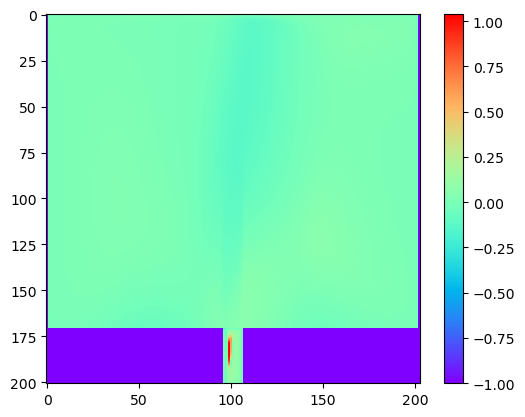

[[-1.00000000e+00  0.00000000e+00  5.87950710e-04 ...  5.87964604e-04
   0.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00  0.00000000e+00  2.89826910e-03 ...  1.03251571e-02
   0.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00  0.00000000e+00  3.94266145e-03 ...  1.32263834e-02
   0.00000000e+00 -1.00000000e+00]
 ...
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 ... -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 ... -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 ... -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]]


In [51]:
array2 = process_matrix(empty_matrix)
# Построение графика заполнения плоскости (heatmap)
plt.imshow(array2, cmap='rainbow', interpolation='nearest')
plt.colorbar()  # Добавление цветовой шкалы
plt.show()
print(array2)



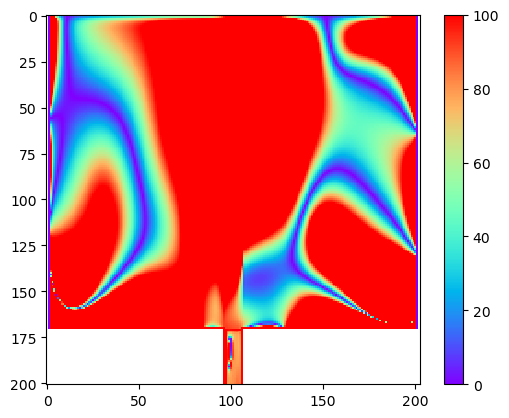

In [52]:
trx = np.flipud(matrixes[0].copy())
it = np.nditer(trx, flags=['multi_index'], op_flags=['readwrite'], order='C')
while not it.finished:
    # Получаем текущий индекс
    i, j = it.multi_index
    if trx[i, j] != -1:
        if trx[i, j] == 0:
            trx[i, j] == np.nan
        else:
            err = abs(array2[i,j] - trx[i, j]) * 100 /trx[i, j]

            trx[i, j] = err 
        # Переходим к следующему элементу с учетом шага матрицы 3x3
    it.iternext()
min_value = 0
max_value = 2
bad_color = 'gray'
new_matrix = np.where(trx == -1, np.nan, trx.copy())
plt.imshow(new_matrix, cmap='rainbow', interpolation='nearest')
plt.clim(0, 100)
plt.colorbar()  # Добавление цветовой шкалы

plt.show()